In [1]:
import numpy as np
import pandas as pd
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import io, segmentation, measure, filters
import cv2
from scipy import ndimage
import numpy as np
import tifffile
import cv2
import matplotlib.pyplot as plt

# Traditional Approach

In [2]:
def preprocess_for_ml_with_color(image, target_size=(512, 512)):
    """
    Enhanced preprocessing pipeline preserving color information.
    """
    # 1. Convert BGR to RGB if needed
    if len(image.shape) == 3:
        # Keep all color channels
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
    else:
        # If grayscale, create 3 channel image
        img_rgb = np.stack([image] * 3, axis=-1)
    
    # 2. Resize while preserving aspect ratio
    resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)
    
    # 3. Enhance each channel separately using CLAHE
    enhanced = np.zeros_like(resized, dtype=np.float32)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    for i in range(3):
        enhanced[:,:,i] = clahe.apply((resized[:,:,i]).astype(np.uint8))
    
    # 4. Normalize to [-1, 1] range
    normalized = (enhanced.astype(float) - 127.5) / 127.5
    
    return normalized


def detect_diatoms(preprocessed_image, confidence_threshold=0.5):
    # Convert back to uint8 for OpenCV
    image_uint8 = ((preprocessed_image + 1) * 127.5).astype(np.uint8)
    
    # Create blob for network input
    blob = cv2.dnn.blobFromImage(
        image_uint8, 
        1/255.0, 
        (512, 512), 
        swapRB=True, 
        crop=False
    )
    
    # Load your trained model here (you'll need to train it first)
    # For now, let's use basic contour detection as placeholder
    gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        blurred, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11,
        2
    )
    
    # Find contours
    contours, _ = cv2.findContours(
        thresh, 
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    detections = []
    for contour in contours:
        # Filter by area
        area = cv2.contourArea(contour)
        if area > 150 and area < 5000:  # Adjust these thresholds
            x, y, w, h = cv2.boundingRect(contour)
            detections.append({
                'bbox': [x, y, w, h],
                'confidence': 1.0,  # Placeholder
                'area': area
            })
    
    return detections

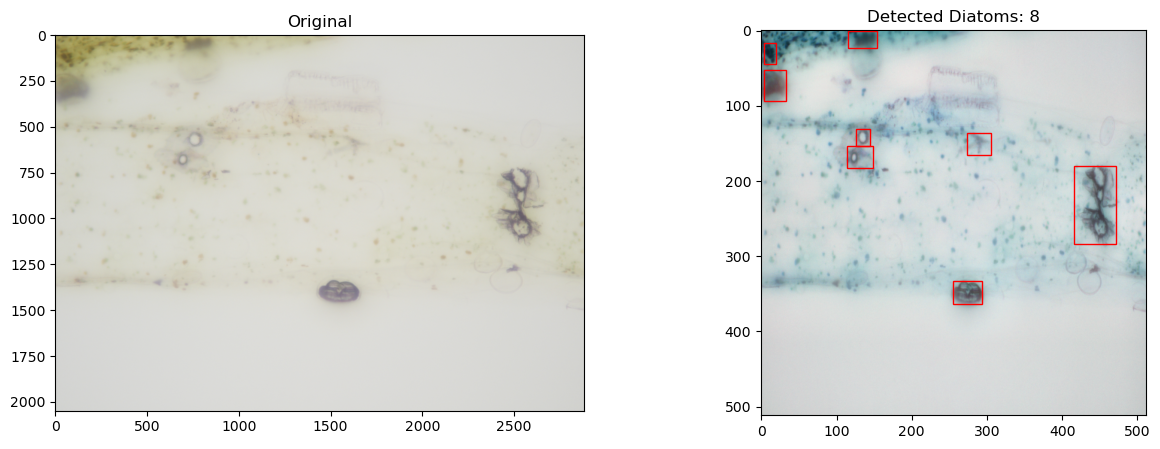

Found 8 potential diatoms
Area statistics:
Min area: 179.0
Max area: 1592.0
Mean area: 519.5


In [16]:
if __name__ == "__main__":
    # Load test image
    test_image = tifffile.imread("/projects/genomic-ml/da2343/diatom/train/Green 45 ambient A 12.tif")
    
    # Process with color preservation
    processed_ml_color = preprocess_for_ml_with_color(test_image)
    
    # Detect diatoms
    detections = detect_diatoms(processed_ml_color)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.imshow(test_image)
    ax1.set_title('Original')
    
    # Convert back to 0-1 range for visualization
    processed_vis = (processed_ml_color + 1) / 2
    ax2.imshow(processed_vis)
    
    # Draw detections
    for det in detections:
        x, y, w, h = det['bbox']
        rect = plt.Rectangle(
            (x, y), w, h,
            fill=False,
            color='red',
            linewidth=1
        )
        ax2.add_patch(rect)
    
    ax2.set_title(f'Detected Diatoms: {len(detections)}')
    plt.show()
    
    # Print detection statistics
    print(f"Found {len(detections)} potential diatoms")
    print("Area statistics:")
    areas = [d['area'] for d in detections]
    print(f"Min area: {min(areas):.1f}")
    print(f"Max area: {max(areas):.1f}")
    print(f"Mean area: {np.mean(areas):.1f}")

In [ ]:
# save the plt graph
plt.savefig('traditional_00.png')
